In [1]:
import os
import sys
import time
import rdkit
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


sys.path.insert(0, '../../')
from jtnn.mol_tree import *

In [2]:
lg = rdkit.RDLogger.logger() 
lg.setLevel(rdkit.RDLogger.CRITICAL)

In [3]:
all_df_qdb9 = pd.read_csv("./qdb9/gdb9_prop_smiles.csv")
zinc_subdict_qdb9 = pd.read_csv("./reg_data/scaled/info.txt", index_col=0)

In [4]:
(all_df_qdb9.lumo*27.21).mean()

0.3026777112895396

In [5]:
print("Mean \t Var")
(all_df_qdb9.lumo*27.21).mean(), (all_df_qdb9.lumo*27.21).var()

Mean 	 Var


(0.3026777112895396, 1.631062214890011)

In [6]:
print("Mean \t Var")
(all_df_qdb9.homo*27.21).mean(), (all_df_qdb9.homo*27.21).var()

Mean 	 Var


(-6.529765990842889, 0.3626404075288911)

In [4]:
print("Full QM9 database")
print("Mean: ")
print(all_df_qdb9[["homo", "lumo", 'gap']].mean(), end='\n\n')
print("Var: ")
print(all_df_qdb9[["homo", "lumo", 'gap']].var(), end="\n\n")

print("Subset of molecules with compatable dictionary with zinc")
print("Mean: ")
print(zinc_subdict_qdb9[["mean"]], end='\n\n')
print("Var: ")
print(zinc_subdict_qdb9[["var"]])

Full QM9 database
Mean: 
homo   -0.239977
lumo    0.011124
gap     0.251100
dtype: float64

Var: 
homo    0.000490
lumo    0.002203
gap     0.002258
dtype: float64

Subset of molecules with compatable dictionary with zinc
Mean: 
          mean
homo -0.243919
lumo  0.013865
gap   0.257783

Var: 
           var
homo  0.000341
lumo  0.002096
gap   0.002089


In [21]:
def get_mean_reg(df, column, loss):
    mean = float(df[[column]].mean())
    return loss(np.array(df[[column]]).flatten(), np.ones(len(df[[column]]))*mean)

def mae(y, y_pred):
    return (np.abs(y - y_pred)).mean()

def mse(y, y_pred):
    return ((y - y_pred)**2).mean()

In [22]:
print("MAE metrics")
print("Mean predictor homo:\n\t", get_mean_reg(all_df_qdb9, "homo", mae), end="\n\n")
print("Mean predictor lumo:\n\t", get_mean_reg(all_df_qdb9, "lumo", mae), end="\n\n")
print("MSE metrics")
print("Mean predictor homo:\n\t", get_mean_reg(all_df_qdb9, "homo", mse), end="\n\n")
print("Mean predictor lumo:\n\t", get_mean_reg(all_df_qdb9, "lumo", mse), end="\n\n")

MAE metrics
Mean predictor homo:
	 0.01628957060509455

Mean predictor lumo:
	 0.03865300630765167

MSE metrics
Mean predictor homo:
	 0.0004897967135337611

Mean predictor lumo:
	 0.0022029782005431315



In [47]:
molecule_counter = {}
with open("qdb9/all.txt", "r") as file:
    for it, smiles in enumerate([x.replace("\n", "").strip() for x in file.readlines()]):
        mol = MolTree(smiles)
        for c in mol.nodes:
            if not c.smiles in molecule_counter:
                molecule_counter[c.smiles] = set([it])
            else:
                molecule_counter[c.smiles].add(it)

RDKit WARNING: [11:55:18] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [11:55:18]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [11:55:18] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [11:55:18]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [11:55:32] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [11:55:32]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [11:55:32] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [11:55:32]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [11:57:09] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [11:57:09]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [11:57:09] Conflicting single bond direc

In [86]:
mols, counts = [], []
for mol, idxes in molecule_counter.items():
    mols.append(mol)
    counts.append(len(idxes))

In [88]:
stats = pd.DataFrame({"Names":mols, "Counts":counts})
stats_10 = stats.sort_values(by="Counts", ascending=False).iloc[:(np.sort(stats.Counts)[::-1] > 10).sum()]

In [164]:
stats_10.Names.to_csv("vocab_prunned_10.txt", header=None, index=None)

In [114]:
for i in [5, 10, 20, 40, 80, 160]:
    print(i, ":", (np.sort(stats.Counts)[::-1] > i).sum())

5 : 443
10 : 331
20 : 183
40 : 147
80 : 101
160 : 67


In [ ]:
from CGRtools import SMILESRead
from CGRtools.exceptions import InvalidAromaticRing

smiles = set()
with SMILESRead("zinc/all.txt", ignore=True) as f:
    for n,i in enumerate(f):
        try:
            i.canonicalize()
        except:
            continue
        smiles.add(str(i))
        if not (n%100):
            print(len(smiles))
        
    else:
        last = n

len(smiles)

## Experiments Infos

In [32]:
def plot_training_info(df):
    plt.figure(figsize=(22, 8))
    
    ax = plt.subplot(251)
    ax.plot(df.Step)
    ax.set_title("Step")
    
    ax = plt.subplot(252)
    ax.plot(df.Loss)
    ax.set_title("Loss")
    
    ax = plt.subplot(253)
    ax.plot(df.Beta)
    ax.set_title("Beta")
    
    ax = plt.subplot(254)
    ax.plot(df.KL)
    ax.set_title("KL")
        
    ax = plt.subplot(255)
    ax.plot(df.Word)
    ax.set_title("Word")
    
    ax = plt.subplot(256)
    ax.plot(df.Topo)
    ax.set_title("Topo")
    
    ax = plt.subplot(257)
    ax.plot(df.Assm)
    ax.set_title("Assm")
    
    ax = plt.subplot(258)
    ax.plot(df.PNorm)
    ax.set_title("PNorm")
    
    ax = plt.subplot(259)
    ax.plot(df.GNorm)
    ax.set_title("GNorm")
    
    ax = plt.subplot(2, 5, 10)
    ax.plot(df.LR)
    ax.set_title("LR")
    
    
    plt.show()

In [46]:
data_path = "../vae_model/qdb9_prunned_256/"
data = pd.read_csv(data_path+"verbose.csv", index_col=0)

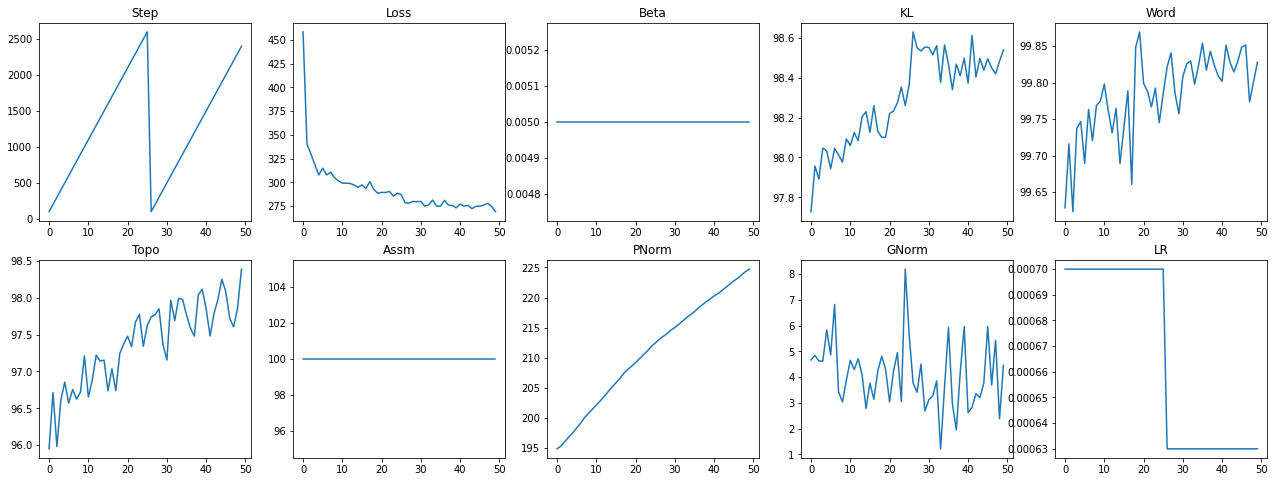

In [47]:
plot_training_info(data)